In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import lightning as pl
import corner

**[Note: I have shamelessly stolen this from [this github repo](https://github.com/smsharma/sbi-lecture-mit/blob/main/tutorial.ipynb)]**

## What is a simulation?

The basic workflow for any sort of MCMC learning in astronomy is to write a simulator. What this means is that we take some underlying vector of parameters $\vec{\theta}$ and write a function which translates that into some sort of observation $f(\vec{\theta})$. This is the forward model, and it's what we mean by a "simulation". In the context of learning $T_{\text{eff}}$ and $\log g$ for a given white dwarf, the steps of the forward model are generally these:
1. Read in a value for $T_{\text{eff}}$ and $\log g$.
2. Use an interpolator to convert $T_{\text{eff}}$ and $\log g$ to a model spectrum.
3. Use `pyphot` to convolve the spectrum to filter bands of interest.

Prediction then is pretty easy. What MCMC used for is **inference**, which is basically the process of inverting $f(\vec{\theta})$ to get $\vec{\theta}$. The people who talk about MCMC on stack exchange are throwing bricks at me and yelling about how MCMC isn't for learning parameters, it's for eXPlOriNG paRAMeTEr SpAceS, but that's just how it's used practically.

## 1.0 Gaussian on a Power Law

Let's consider an explicit model with $\vec{\theta} = (A_{\text{s}}, A_\text{b}, \mu, \sigma, \gamma)$, and forward model:

$$y = f(\vec{\theta}) = A_\text{s}\exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) + A_\text{b} x^\gamma$$

### 1.1 Explicit Likelihood Functions

In [3]:
def forward(x, amp_s, mu_s, std_s, amp_b, exp_b):
    x_norm = amp_s * np.exp(-(x - mu_s)**2 / (2 * std_s**2))
    x_pow = amp_b * x**exp_b
    return x_norm + x_pow

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = forward(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

What we've done here is calculate a noiseless underlying signal, `x_mu`, from an underlying set of parameters. We can imagine that we're trying to learn what those underlying parameters are. If we had access to the actual values of `x_mu`, we could perfectly re-create the parameters that were used to generate it. In practice though, we'll never have that. We're going to get some noisy sample that carries some information relating to that distribution.

Next, we're going to write a function that can simulate a noisy observation using a Poisson distribution. We can imagine that we're measuring the number of electrons incident on a CCD, which means that we're going to be dealing with a Poisson distribution whose mean is the true parameter value. We'll add in $1\sigma$ errorbars.

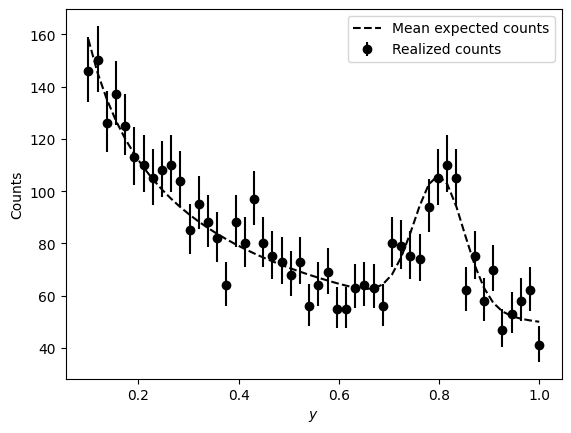

In [4]:
def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")
plt.xlabel("$y$")
plt.ylabel("Counts")
plt.legend()

We can write down an explicit function for log-likelihood of a set of parameters. We know the values of the `y` vectors, and we can generate a proposed observation using the function $f(\vec{\theta}, \{y_i\})$ which we'll compare to the observed values of `x`. We'll compute the probability that the observation came from this particular set of parameters using the standard probability mass function for a Poisson distribution:

$$p(\vec{\theta}|{x_i}) \propto \Pi_i \frac{f(\vec{\theta}, y_i))^{x_i} \exp(-f(\vec{\theta}, y_i))}{x_i!} \implies \log L = \sum_i \frac{f(\vec{\theta}, y_i))^{x_i} \exp(-f(\vec{\theta}, y_i))}{x_i!}$$ 

In [5]:
def log_likelihood(theta, y, x):
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    x_pred = forward(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, x_pred).sum()

For the sake of simplicity, let's fix our values of everything but the gaussian amplitude and standard deviation. Putting things in two dimensions will make it easier to visualize this.

In [6]:
def log_likelihood_sig(theta, y, x):
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    x_pred = forward(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, x_pred).sum()

log_likelihood_sig([50, 0.8, 0.05, 50, -0.5], y, x)

np.float64(-180.33554478299934)

We can use basinhopping, which is a technique I've never heard of, to get a quick estimate of the parameters. We've basically defined an explicit loss function, the negative log likelihood, which we're trying to minimize. We can also use `emcee` to estimate the posteriors. In a standard approach, this is where we'd stop.

In [7]:
# Initial guess for the parameters
initial_guess = [100., 0.1, 0.05, 50, -0.5]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1), (0, 1), (0, 200), (-1, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_likelihood_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))

/tmp/ipykernel_571837/3364543357.py:2: RuntimeWarning: divide by zero encountered in divide
  x_norm = amp_s * np.exp(-(x - mu_s)**2 / (2 * std_s**2))
/tmp/ipykernel_571837/3364543357.py:2: RuntimeWarning: invalid value encountered in divide
  x_norm = amp_s * np.exp(-(x - mu_s)**2 / (2 * std_s**2))


MLE parameters: [75.19753643  0.          0.18046966 67.85446321 -0.07937386]; true parameters: (50, 0.8)


In [8]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s, std_s, amp_b, exp_b = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood_sig(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 5, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/arsen/miniconda3/envs/seismo/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:19<00:00, 250.07it/s] 


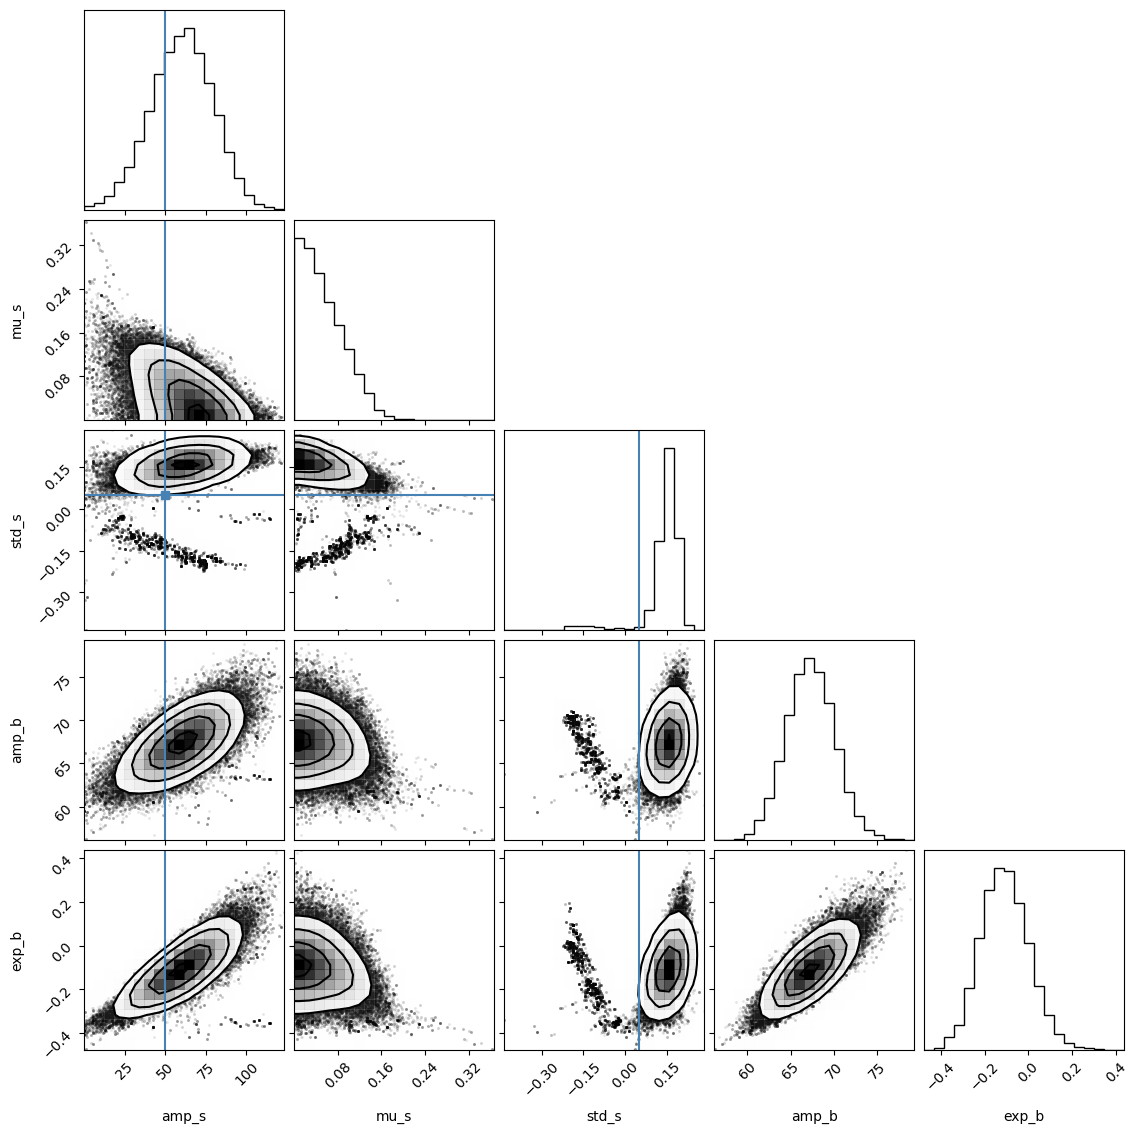

In [9]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s", "std_s", "amp_b", "exp_b"], truths=[50, 0.8, 0.05, 50, -0.5], smooth=1.);

### 1.2 Implicit Likelihood Functions

Now, let's do some SBI. The key thing to realize here is that in calculating the forward model, we actually already have a lot of information about the likelihood. That information is just being translated into a useable form by the log likelihood function. Let's try and write a function that actually simulates what we observe. We know that there is an underlying distribution controlled by some set of parameters, and we know that there is a Poisson-distributed noise function perturbing our observations from their true values. Then the simulated signal would be:

In [10]:
def bump_simulator(theta, y):
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    x_mu = forward(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu) # insert poisson noise
    return x

# Test it out
bump_simulator([50, 0.8, 0.05, 50, -0.5], y)

array([160, 137, 146, 121, 131, 126, 140,  92,  87,  99,  95,  88,  82,
        87,  85,  76,  95,  75,  82,  72,  79,  66,  66,  66,  65,  60,
        65,  71,  59,  69,  68,  68,  56,  83,  66,  71,  83, 117, 118,
        97,  92,  82,  84,  56,  54,  56,  59,  56,  43,  53])

What MCMC is doing is called Approximate Bayesian Computation (ABC). Essentially we draw some $\vec{\theta}$ from a certain distribution, forward model it, and then compute a summary statistic comparing the real data to the forward modeled data. If that summary statistic is within some threshold, we keep that parameter vector. If it's not, we reject it. For instance, a simple version of an ABC algorithm using a $\Chi^2$ likelihood would be:

In [11]:
def abc(y, x, eps_thresh=500, n_samples=1000):
    samples = [] # initialize the chain
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # keep simulating until we reach the necessary n_samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0,0], high=[200,1]) # these are our priors
        x_fwd = bump_simulator(params, y) # simulate the observation
        eps = np.sum(np.abs(x - x_fwd)**2) / len(x) # calculate the distance metric
        total_attempts += 1

        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)
    
n_samples = 5_000
post_samples = abc(y, x, eps_thresh=200, n_samples=n_samples)

Accepted Samples:   0%|          | 0/5000 [00:00<?, ?samples/s]

ValueError: not enough values to unpack (expected 5, got 2)

This works, which we can see by plotting the chain, but we had to compute a lot of samples, and the distribution we got was actually kind of crap. Also, on my laptop this takes over two minutes to run which is not remotely scalable. We'll want to try and get a better and faster method.

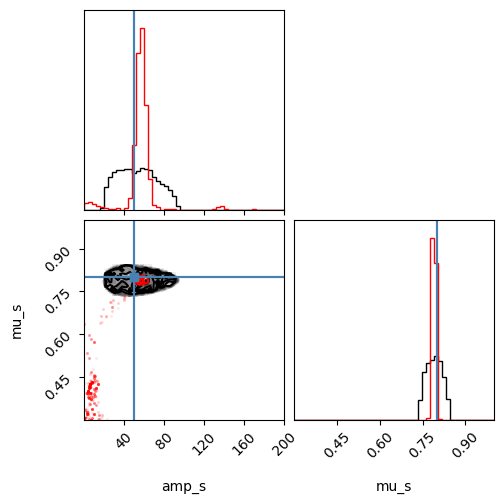

In [153]:
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples))*n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

### 1.3 Neural Likelihood-Ratio Estimation (NRE)

The goal here is to train a machine learning model to evaluate the likelihood of a parameter quickly. We're going to do this by drawing the same set of samples from two distributions: one of which is the real joint distribution $p(x|\theta)$ and the other which is the independent distribution $p(x)p(\theta)$. The point of the independent distribution is to serve as a completely random baseline against which we can compare. Then, we're going to train a simple MLP that takes as input a concatenated vector of $(\vec{\theta}, x)$ and outputs a single logit. That logit can range from $0$, meaning that the input $(\vec{\theta}, x)$ is drawn from the independent distribution, to $1$, meaning that it is drawn from the joint distribution.

In [20]:
n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0, 0, 0, -1], high=[200, 1, 1, 200, 1], size=(n_train, 5))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:04<00:00, 11413.96it/s]


In [21]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

Now we have 50,000 pairs of $\vec{\theta}$ parameters and their simulated outputs, and we have a MLP we can play with. Now we're going to write a loss function that can estimate the likelihood ratio. The steps for computing the loss of this function are:
1. Take the `x` array inputted into the model and call `x.repeat_interleave(2, dim=0)`. This creates a duplicate of every element of the torch tensor that is fed into the model. So for instance, if the torch tensor is `[[1,2],[3,4],[5,6]]`, calling this function would map that to `[[1,2], [1,2], [3,4], [3,4], [5,6], [5,6]]`.
2. Randomly shuffle the $\vec{\theta}$ array along the zeroth dimension.
3. Stack the $\vec{\theta}$ and shuffled $\vec{\theta}$ arrays such that along the zeroth dimension, even-numbered indicies of the stacked `theta` array correctly match the pairs of $(\vec{\theta}, x)$ and odd-numbered indicies are associated with the randomly shuffled independent distribution.
4. Now, correctly label each pair of $(\vec{\theta}, x)$. The label array should be an alternating array like `[1,0,1,0,...]` where `1` corresponds to a parameter set drawn from the correct joint distribution and `0` corresponds to the independent distribution.
5. Pass the $(\vec{\theta}, x)$ pairs into the classifier returning a logit, then compute the loss between that logit and the correct label.

In [22]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):

        # 1: Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # 2: Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # 3: Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # 4: Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # 5: Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()
        return nn.BCELoss(reduction='none')(probs, labels)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [24]:
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=5)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.7098, 0.6768, 0.7096, 0.6765, 0.7099, 0.6766, 0.7098, 0.6769, 0.7084,
        0.6777, 0.7097, 0.6765, 0.7095, 0.6768, 0.7076, 0.6781, 0.7098, 0.6766,
        0.7098, 0.6765, 0.7103, 0.6762, 0.7106, 0.6768, 0.7098, 0.6766, 0.7098,
        0.6764, 0.7096, 0.6768, 0.7101, 0.6766, 0.7107, 0.6762, 0.7101, 0.6760,
        0.7100, 0.6765, 0.7086, 0.6772, 0.7093, 0.6776, 0.7099, 0.6769, 0.7081,
        0.6781, 0.7085, 0.6774, 0.7096, 0.6773, 0.7088, 0.6773, 0.7101, 0.6763,
        0.7099, 0.6767, 0.7103, 0.6763, 0.7100, 0.6769, 0.7089, 0.6771, 0.7100,
        0.6767, 0.7100, 0.6766, 0.7099, 0.6768, 0.7102, 0.6766, 0.7099, 0.6764,
        0.7093, 0.6771, 0.7098, 0.6769, 0.7101, 0.6763, 0.7091, 0.6773, 0.7100,
        0.6763, 0.7090, 0.6769, 0.7097, 0.6772, 0.7091, 0.6773, 0.7095, 0.6774,
        0.7102, 0.6767, 0.7099, 0.6768, 0.7096, 0.6768, 0.7090, 0.6776, 0.7095,
        0.6771, 0.7096, 0.6767, 0.7096, 0.6766, 0.7096, 0.6767, 0.7100, 0.6767,
        0.7101, 0.6767, 0.7101, 0.6766, 

In [25]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [26]:
trainer = pl.Trainer(max_epochs=20, enable_checkpointing=False)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.3 K | train
--------------------------------------------------
73.3 K    Trainable params
0         Non-trainable params
73.3 K    Total params
0.293     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [27]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
        
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().numpy()

theta_test = np.array([90, 0.8, 0.05, 50, -0.5])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

array(4.3384895, dtype=float32)

In [28]:
def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

In [162]:
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/arsen/miniconda3/envs/seismo/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:10<00:00, 38.42it/s] 


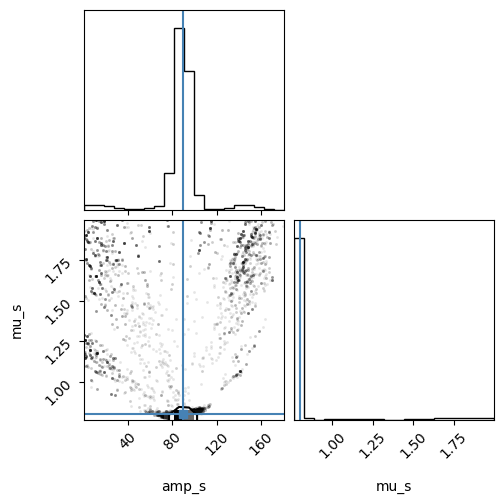

In [ ]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

### 1.4 Neural Posterior Estimation (NPE)


In [29]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [30]:
def get_flow(d_in=5, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """
    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 5]) torch.Size([2, 100])


In [35]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.d_in = 5
        self.featurizer = featurizer
        self.flow = get_flow(d_in=self.d_in, d_hidden=32, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        # np.log(1.0/(np.sqrt(2*np.pi)*pr[1]))-0.5*(theta[i]-pr[0])**2/pr[1]**2
        #prior, x = x[:2*self.d_in], x[2*self.d_in:]
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)# - log_prior(theta, prior) # insert priors here

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [36]:
npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([11.9285, 11.9226, 11.5254, 11.7124, 12.2226, 12.1670, 11.5499, 12.1509,
        11.9819, 12.0203, 11.5937, 12.2051, 12.0394, 11.9227, 11.6272, 12.2906,
        11.5865, 11.8092, 11.7581, 11.4977, 12.3498, 12.0287, 11.8970, 11.8160,
        12.1461, 11.5989, 11.6589, 12.6376, 11.3934, 12.5289, 11.8164, 12.4468,
        11.5856, 12.0126, 12.2971, 11.8224, 12.1535, 11.5876, 11.7312, 11.8453,
        11.5793, 11.8988, 11.6965, 12.0230, 12.3955, 12.0342, 12.3701, 11.7864,
        12.9351, 11.7229, 11.7609, 12.1575, 11.7360, 11.9660, 11.5814, 11.7393,
        11.6607, 11.4782, 11.7369, 12.2926, 11.8435, 12.6145, 11.6544, 12.0647],
       grad_fn=<NegBackward0>)

In [1]:
theta_samples[0]

NameError: name 'theta_samples' is not defined

In [69]:
trainer = pl.Trainer(max_epochs=40, enable_checkpointing=False)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 74.6 K | train
1 | flow       | Flow       | 25.5 K | train
--------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.401     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [85]:
theta_test = np.array([50, 0.8, .02, 50, -0.5])
x_test = bump_simulator(theta_test, y)

In [86]:
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

In [87]:
%%timeit
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean


322 ms ± 65.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


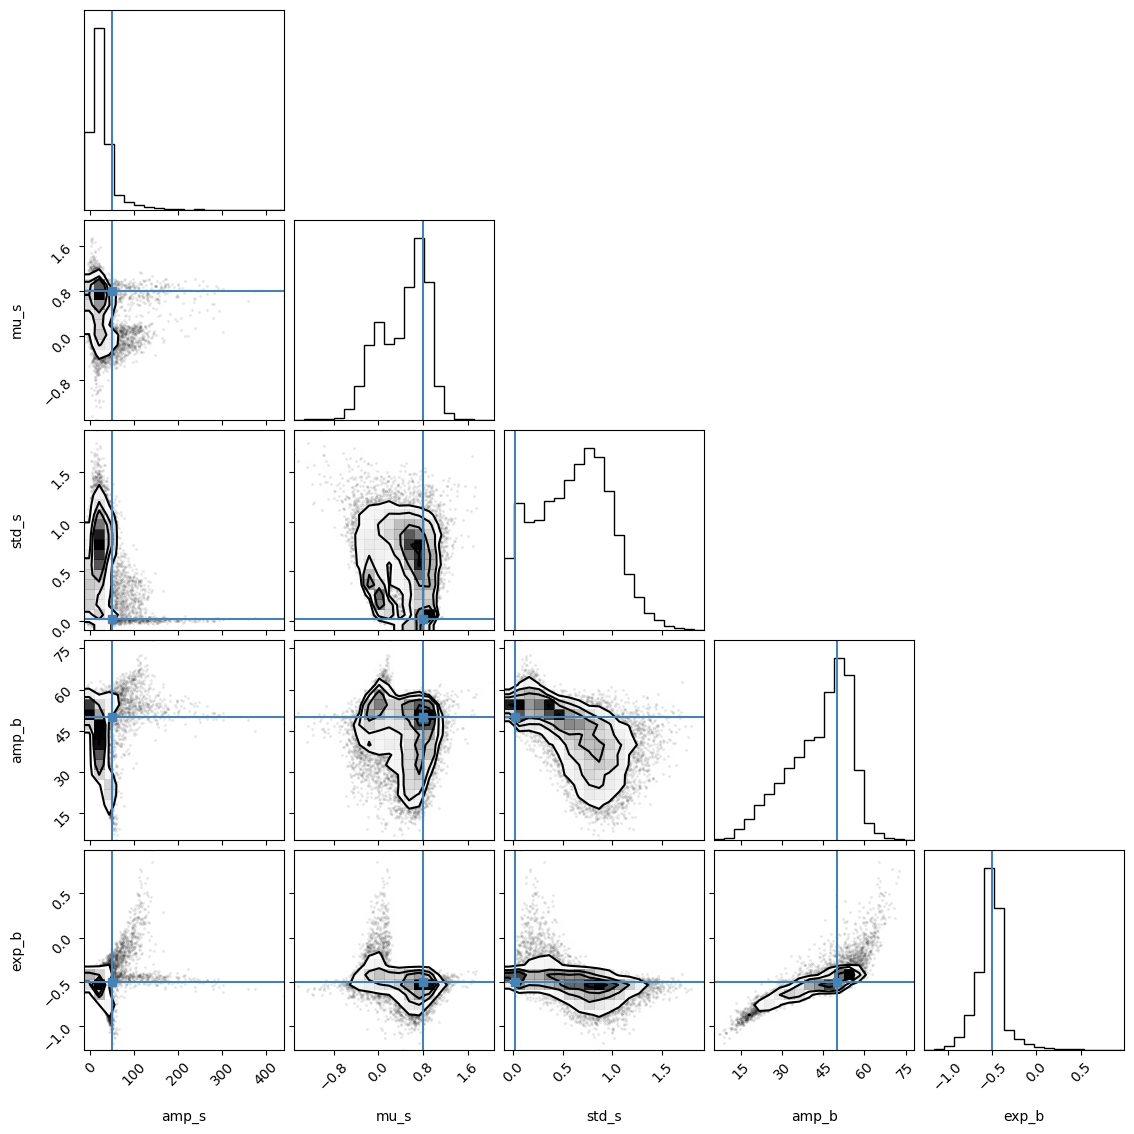

In [88]:
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()
corner.corner(samples_test[0], labels=["amp_s", "mu_s", "std_s", "amp_b", "exp_b"], truths=theta_test);

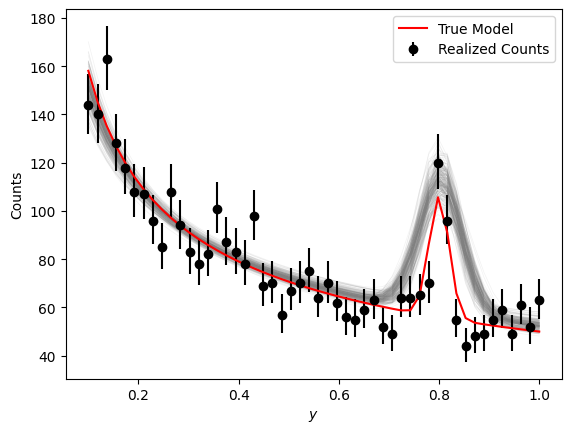

In [89]:
x_err = np.array([poisson_interval(k) for k in x_test.T]).T
x_mu = forward(y, amp_s=theta_test[0], mu_s=theta_test[1], std_s=theta_test[2],  # Signal params
                    amp_b=theta_test[3], exp_b=theta_test[4])  # Background params

sampled_indices = np.random.choice(samples_test[0].shape[0], 250, replace=False)
sampled_params = flat_samples[sampled_indices]

plt.errorbar(y, x_test, yerr=x_err, c = 'k', label='Realized Counts', fmt='o')
plt.plot(y, x_mu, c = 'red', label='True Model')

for params in sampled_params:
    sampled_y = forward(y, amp_s=params[0], mu_s=params[1], std_s=params[2], amp_b=params[3], exp_b=params[4])
    plt.plot(y, sampled_y, color='gray', alpha=0.1, linewidth=0.5, zorder=0)

plt.xlabel("$y$")
plt.ylabel("Counts")
plt.legend()

In [63]:
sampled_params[0]

array([ 5.96732224e+01,  8.04281639e-01,  3.63680176e-02,  5.00659287e+01,
       -5.06649136e-01])